In [122]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tensorflow import keras
from sklearn.metrics import accuracy_score

for module in mpl, np, pd, sklearn, torch, keras:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42


matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.5.2
torch 2.6.0+cu126
keras._tf_keras.keras 3.8.0
cuda:0


In [104]:
imdb = keras.datasets.imdb
vocab_size = 10000
index_from = 3

(train_data, train_labels), (valid_data, valid_labels) = imdb.load_data(
    num_words=vocab_size, 
    index_from=index_from, 
    cache_dir="D:\\python\\2025\\04.deep_learning\\data\\imdb.npz")

In [ ]:
word_index = imdb.get_word_index()

word2index = {word : idx + 3 for word, idx in word_index.items()}

word2index.update({
    "[PAD]" : 0,
    "[BOS]" : 1,
    "[UNK]" : 2,
    "[EOS]" : 3,
})

index2word = {idx : word for word, idx in word2index.items()}

0

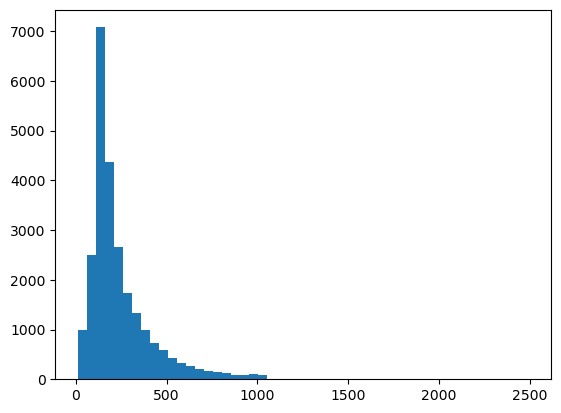

In [ ]:
len_list = [len(txt) for txt in train_data]

plt.hist(len_list, bins=50)
plt.show()

In [44]:
class Tokenizer:
    def __init__(self, word2index, index2word, max_length=500, pad_idx=0, bos_idx=1, unk_idx=2, eos_idx=3):
        self.word2index = word2index
        self.index2word = index2word
        self.max_length = max_length
        self.pad_idx = pad_idx
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.unk_idx = unk_idx

    def encode(self, text_list):
        max_length = min(self.max_length - 2, max([len(text) for text in text_list]))
        text_index_list = []
        for text in text_list:
            index_list = [self.word2index.get(word, self.unk_idx) for word in text]

            if len(index_list) < max_length:
                index_list += [self.pad_idx] * (max_length - len(index_list))
            else:
                index_list = index_list[:max_length]
            
            index_list = [self.bos_idx] + index_list + [self.eos_idx]
            
            text_index_list.append(index_list)
        return torch.tensor(text_index_list)
    
    def decode(self, text_index_list, rm_bos=True, rm_eos=True, rm_pad=True, split=False):
        text_list = []
        for index_list in text_index_list:
            text = []
            for index in index_list:
                word = self.index2word.get(index, "[UNK]")
                if rm_bos and word == "[BOS]":
                    continue
                if rm_eos and word == "[EOS]":
                    break
                if rm_pad and word == "[PAD]":
                    break
                text.append(word)
            
            text_list.append(text if split else " ".join(text))
        
        return text_list


tokenizer = Tokenizer(word2index=word2index, index2word=index2word)

In [167]:
print(train_data.shape)
print()
print(train_data[0:3])
print()
print(f"train_data[0]_len = {len(train_data[0])}, train_data[1]_len = {len(train_data[1])}, train_data[2]_len = {len(train_data[2])}")
print()
print(tokenizer.decode(train_data[0:1]))

(25000,)

[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 194, 8255, 78, 228, 5,

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, data, labels, remain_length=True):
        if remain_length:
            self.data = tokenizer.decode(data, rm_bos=False, rm_eos=False, rm_pad=False)
        else:
            self.data = tokenizer.decode(data)
        self.labels = labels

    def __getitem__(self, index):
        text = self.data[index]
        label = self.labels[index]
        return text, label
    
    def __len__(self):
        return len(self.data)

In [160]:
def collate_fn(batch):
    text_list = [item[0].split() for item in batch]
    label_list = [item[1] for item in batch]
    text_list = tokenizer.encode(text_list).to(dtype=torch.int)
    label_list = torch.tensor(label_list).reshape(-1, 1).to(dtype=torch.float)

    return text_list, label_list

In [161]:
train_dataset = IMDBDataset(train_data, train_labels)
valid_dataset = IMDBDataset(valid_data, valid_labels)

batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
'''
    Embedding矩阵(实际上是一个查找表) 
        行数是词表大小(词的个数)，列数是词向量维度(代表词的低维向量的维数)
'''
class AddingModel(nn.Module):
    def __init__(self, embedding_dim = 16, hidden_dim = 64, vocab_size = vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.layer = nn.Linear(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)   # [batch_size, seq_length, embedding_dim] -> [128, 500, 16]
        x = x.permute(0, 2, 1)  # [128, 16, 500] 500个词求平均以代表文章的语义
        x = self.pool(x)
        x = x.squeeze(-1)
        x = self.layer(x)
        x = self.fc(x)

        return x

In [130]:
@torch.no_grad()
def evaluating(model, valid_dataloader, loss_function):
    loss_list = []
    pred_list = []
    label_list = []

    for data, label in valid_dataloader:
        data = data.to(device)
        label = label.to(device)

        logits = model(data)
        loss = loss_function(logits, label)
        loss_list.append(loss.item())

        pred = logits > 0
        pred_list.extend(pred.cpu().numpy().tolist())
        label_list.extend(label.cpu().numpy().tolist())
    
    acc = accuracy_score(label_list, pred_list)

    return np.mean(loss_list), acc

In [131]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            self.best_metric = metric
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience


In [134]:
def training(
        model,
        train_dataloader,
        valid_dataloader,
        epoch,
        loss_function,
        optimizer,
        early_stop_cb = None,
        eval_step = 500
):
    record_dict = {"train":[], "valid":[]}
    global_step = 0
    model.train()

    with tqdm(total=len(train_dataloader) * epoch) as pbar:
        for epoch_id in range(epoch):
            for data, label in train_dataloader:
                data = data.to(device)
                label = label.to(device)

                optimizer.zero_grad()
                logits = model(data)
                loss = loss_function(logits, label)
                loss.backward()
                optimizer.step()
                
                loss = loss.cpu().item()
                pred = logits > 0
                acc = accuracy_score(label.cpu().numpy(), pred.cpu().numpy())

                record_dict["train"].append({
                    "loss":loss, "acc":acc, "step":global_step
                })

                if global_step % eval_step == 0:
                    model.eval()
                    valid_loss, valid_acc = evaluating(model, valid_dataloader, loss_function)
                    record_dict["valid"].append({
                        "loss":valid_loss, "acc":valid_acc, "step":global_step
                    })
                    model.train()

                    if early_stop_cb is not None:
                        early_stop_cb(valid_acc)
                        if early_stop_cb.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch":epoch_id})
    
    return record_dict

In [135]:
epoch = 20
model = AddingModel().to(device)
loss_function = F.binary_cross_entropy_with_logits
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
early_stop_cb = EarlyStopCallback()
record = training(
    model,
    train_dataloader,
    valid_dataloader,
    epoch,
    loss_function,
    optimizer,
    early_stop_cb=early_stop_cb,
    eval_step=len(train_dataloader)
)

  0%|          | 0/41680 [00:00<?, ?it/s]

Early stop at epoch 9 / global_step 18756


In [137]:
def plot_learning_curve(record_dict, sample_step = 500):
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    valid_df = pd.DataFrame(record_dict["valid"]).set_index("step")

    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(fig_num*5, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(valid_df.index, valid_df[item], label=f"valid_{item}")
        axs[idx].grid()
        axs[idx].legend()
        axs[idx].set_xlabel("step")
    
    plt.show()

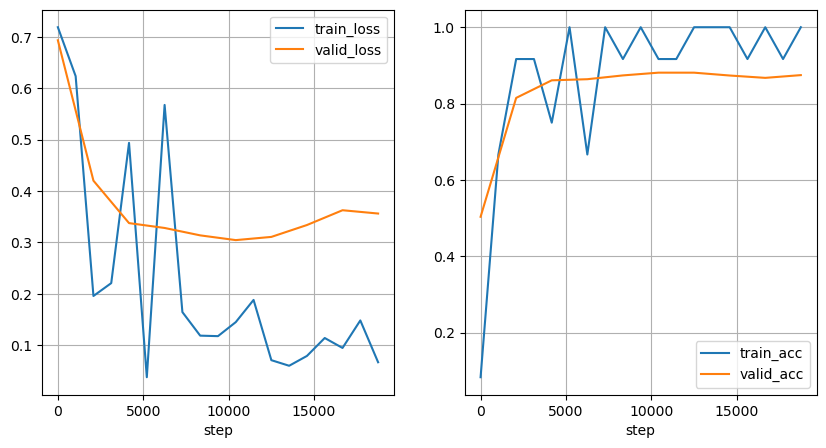

In [146]:
plot_learning_curve(record, len(train_dataloader)//2)

In [147]:
model.eval()
loss, acc = evaluating(model, valid_dataloader, loss_function)
print(f"loss: {loss}, acc: {acc}")

loss: 0.3561779048128256, acc: 0.87456
